# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [2]:
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score


def plot_target_distribution(data, targets):

    counts = data[targets].sum()

    plt.figure(figsize=(7, 3))
    counts.plot(kind="bar", color="skyblue", edgecolor="black")

    plt.title("Num instances of targets")
    plt.xticks(rotation=45)
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    plt.show()


def reduce_attribute(data, attribute_name, fraction):
    """Reduces the amount of instances of an attribute by a fraction"""
    # Extract attribute column
    atribute_column = data[data[attribute_name] == 1]

    # Remove 50 % of other fualts
    atribute_column_sampled = atribute_column.sample(frac=fraction, random_state=21)

    # Get all classes except other faults
    other_classes = data[data[attribute_name] == 0]

    # Stitch togeather
    data = pd.concat([other_classes, atribute_column_sampled])

    return data


def plot_learning_curves(model, X_train, X_test, y_train, y_test, step_size=1000, title="Learning Curves", min_data_length=50):
    train_errors, val_errors = [], []

    # Konverter y_train og y_test til 1D hvis de er one-hot encoded
    y_train = np.argmax(y_train, axis=1)  # Konverter one-hot til 1D labels
    y_test = np.argmax(y_test, axis=1)  # Konverter one-hot til 1D labels

    # Train and predict using train and test set for a range of data
    for m in range(min_data_length, len(X_train), step_size):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_test)

        train_errors.append(1 - accuracy_score(y_train[:m], y_train_predict))
        val_errors.append(1 - accuracy_score(y_test, y_val_predict))

    # Make sure the whole dataset is used and errors are appended
    model.fit(X_train, y_train)
    y_train_predict = model.predict(X_train)
    y_val_predict = model.predict(X_test)

    train_errors.append(1 - accuracy_score(y_train, y_train_predict))
    val_errors.append(1 - accuracy_score(y_test, y_val_predict))

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(train_errors, "r-+", linewidth=2, label="Train error")
    plt.plot(val_errors, "b-", linewidth=3, label="Validation error")
    plt.title(title)
    plt.xlabel("Training set size")
    plt.ylabel("Error (1 - Accuracy)")
    plt.legend()
    plt.grid(True)
    plt.show()




# To plot the confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names, title="Confusion Matrix"):
    y_true = np.argmax(y_true, axis=1) # convert to 1d labels
    y_pred = np.argmax(y_pred, axis=1) 
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()


def print_accuracy(y_pred, y_test):
    """ Input: One-hot encoded predictions and test labels. """
    # Konverter one-hot til enkeltklasseetiketter
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_test_labels = np.argmax(y_test, axis=1) #important to convert pandas df to values

    # Beregn nøyaktighet
    accuracy = accuracy_score(y_test_labels, y_pred_labels)
    print(f"Accuracy: {accuracy:.3f}")
    print(classification_report(y_test_labels, y_pred_labels, target_names=targets))


## Read The Data
First, we need to take a look at the data structure and attributes.
We want to find correlations that can predict useful information. 

In [3]:
import pandas as pd

CSV_FILENAME = "steel_plate.csv" 
CSV_FOLDER_NAME = "Datasets"
CSV_FILEPATH = os.path.join(CSV_FOLDER_NAME, CSV_FILENAME)

try:
    raw_data = pd.read_csv(CSV_FILEPATH)
except Exception as e:
    print(e)

raw_data.head()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,0,584,590,909972,909977,16,8,5,2274,113,...,-0.5000,-0.0104,0.1417,0,0,0,1,0,0,0
1,1,808,816,728350,728372,433,20,54,44478,70,...,0.7419,-0.2997,0.9491,0,0,0,0,0,0,1
2,2,39,192,2212076,2212144,11388,705,420,1311391,29,...,-0.0105,-0.0944,1.0000,0,0,1,0,0,0,0
3,3,781,789,3353146,3353173,210,16,29,3202,114,...,0.6667,-0.0402,0.4025,0,0,1,0,0,0,0
4,4,1540,1560,618457,618502,521,72,67,48231,82,...,0.9158,-0.2455,0.9998,0,0,0,0,0,0,1


## Explanation of Targets and Features

### Explanation of Steel Plate Faults
The following are descriptions of the different steel plate faults.

- **Pastry**: Small patches or irregularities on the surface of the steel plate, typically caused by imperfections in the manufacturing process or handling during transport. These imperfections affect surface smoothness and appearance.

- **Z_Scratch**: Narrow scratches or marks running **parallel** to the rolling direction. Caused by handling, machining, or contact with abrasive materials during production or transportation.

- **K_Scratch**: Similar to Z-Scratches but run **perpendicular** to the rolling direction. Also caused by handling, machining, or abrasive material contact.

- **Stains**: Discolored or contaminated areas on the surface of the steel plate, often caused by rust, oil, grease, or other foreign substances during processing, storage, or handling.

- **Dirtiness**: Presence of dirt or particulate matter on the surface. This includes various types of debris or contaminants that accumulate during manufacturing, handling, or storage.

- **Bumps**: Raised or protruding areas on the surface, caused by irregularities in the manufacturing process, such as uneven rolling or cooling, or by physical damage during handling or transport.

- **Other_Faults**: A broader category encompassing surface imperfections, irregularities, or abnormalities that affect the quality or usability of the steel plate.

---

## Further Information About the Features

The dataset **Steel Plates Faults** contains **27 features** that describe each fault in detail. Below is an explanation of some key features:

### Location Features
- **X_Minimum**: Minimum x-coordinate of the fault.
- **X_Maximum**: Maximum x-coordinate of the fault.
- **Y_Minimum**: Minimum y-coordinate of the fault.
- **Y_Maximum**: Maximum y-coordinate of the fault.

### Size Features
- **Pixels_Areas**: Area of the fault in pixels.
- **X_Perimeter**: Perimeter along the x-axis of the fault.
- **Y_Perimeter**: Perimeter along the y-axis of the fault.

### Luminosity Features
- **Sum_of_Luminosity**: Sum of luminosity values in the fault area.
- **Minimum_of_Luminosity**: Minimum luminosity value in the fault area.
- **Maximum_of_Luminosity**: Maximum luminosity value in the fault area.

### Material and Index Features
- **TypeOfSteel_A300**: Type of steel (A300).
- **TypeOfSteel_A400**: Type of steel (A400).
- **Steel_Plate_Thickness**: Thickness of the steel plate.
- **Edges_Index, Empty_Index, Square_Index, Outside_X_Index, Edges_X_Index, Edges_Y_Index, Outside_Global_Index**: Various index values related to edges and geometry.

### Logarithmic Features
- **LogOfAreas**: Logarithm of the area of the fault.
- **Log_X_Index, Log_Y_Index**: Logarithmic indices related to X and Y coordinates.

### Statistical Features
- **Orientation_Index**: Index describing orientation.
- **Luminosity_Index**: Index related to luminosity.
- **SigmoidOfAreas**: Sigmoid function applied to areas.

In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19219 entries, 0 to 19218
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     19219 non-null  int64  
 1   X_Minimum              19219 non-null  int64  
 2   X_Maximum              19219 non-null  int64  
 3   Y_Minimum              19219 non-null  int64  
 4   Y_Maximum              19219 non-null  int64  
 5   Pixels_Areas           19219 non-null  int64  
 6   X_Perimeter            19219 non-null  int64  
 7   Y_Perimeter            19219 non-null  int64  
 8   Sum_of_Luminosity      19219 non-null  int64  
 9   Minimum_of_Luminosity  19219 non-null  int64  
 10  Maximum_of_Luminosity  19219 non-null  int64  
 11  Length_of_Conveyer     19219 non-null  int64  
 12  TypeOfSteel_A300       19219 non-null  int64  
 13  TypeOfSteel_A400       19219 non-null  int64  
 14  Steel_Plate_Thickness  19219 non-null  int64  
 15  Ed

In [5]:
raw_data.describe()

,id,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,...,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
count,19219.000000,19219.000000,19219.000000,1.921900e+04,1.921900e+04,19219.000000,19219.000000,19219.000000,1.921900e+04,19219.000000,...,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000
mean,9609.000000,709.854675,753.857641,1.849756e+06,1.846605e+06,1683.987616,95.654665,64.124096,1.918467e+05,84.808419,...,0.102742,-0.138382,0.571902,0.076279,0.059837,0.178573,0.029554,0.025235,0.247828,0.341225
std,5548.191747,531.544189,499.836603,1.903554e+06,1.896295e+06,3730.319865,177.821382,101.054178,4.420247e+05,28.800344,...,0.487681,0.120344,0.332219,0.265450,0.237190,0.383005,0.169358,0.156844,0.431762,0.474133
min,0.000000,0.000000,4.000000,6.712000e+03,6.724000e+03,6.000000,2.000000,1.000000,2.500000e+02,0.000000,...,-0.988400,-0.885000,0.119000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4804.500000,49.000000,214.000000,6.574680e+05,6.575020e+05,89.000000,15.000000,14.000000,9.848000e+03,70.000000,...,-0.272700,-0.192500,0.253200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9609.000000,777.000000,796.000000,1.398169e+06,1.398179e+06,168.000000,25.000000,23.000000,1.823800e+04,90.000000,...,0.111100,-0.142600,0.472900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,14413.500000,1152.000000,1165.000000,2.368032e+06,2.362511e+06,653.000000,64.000000,61.000000,6.797800e+04,105.000000,...,0.529400,-0.084000,0.999400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,19218.000000,1705.000000,1713.000000,1.298766e+07,1.298769e+07,152655.000000,7553.000000,903.000000,1.159141e+07,196.000000,...,0.991700,0.642100,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


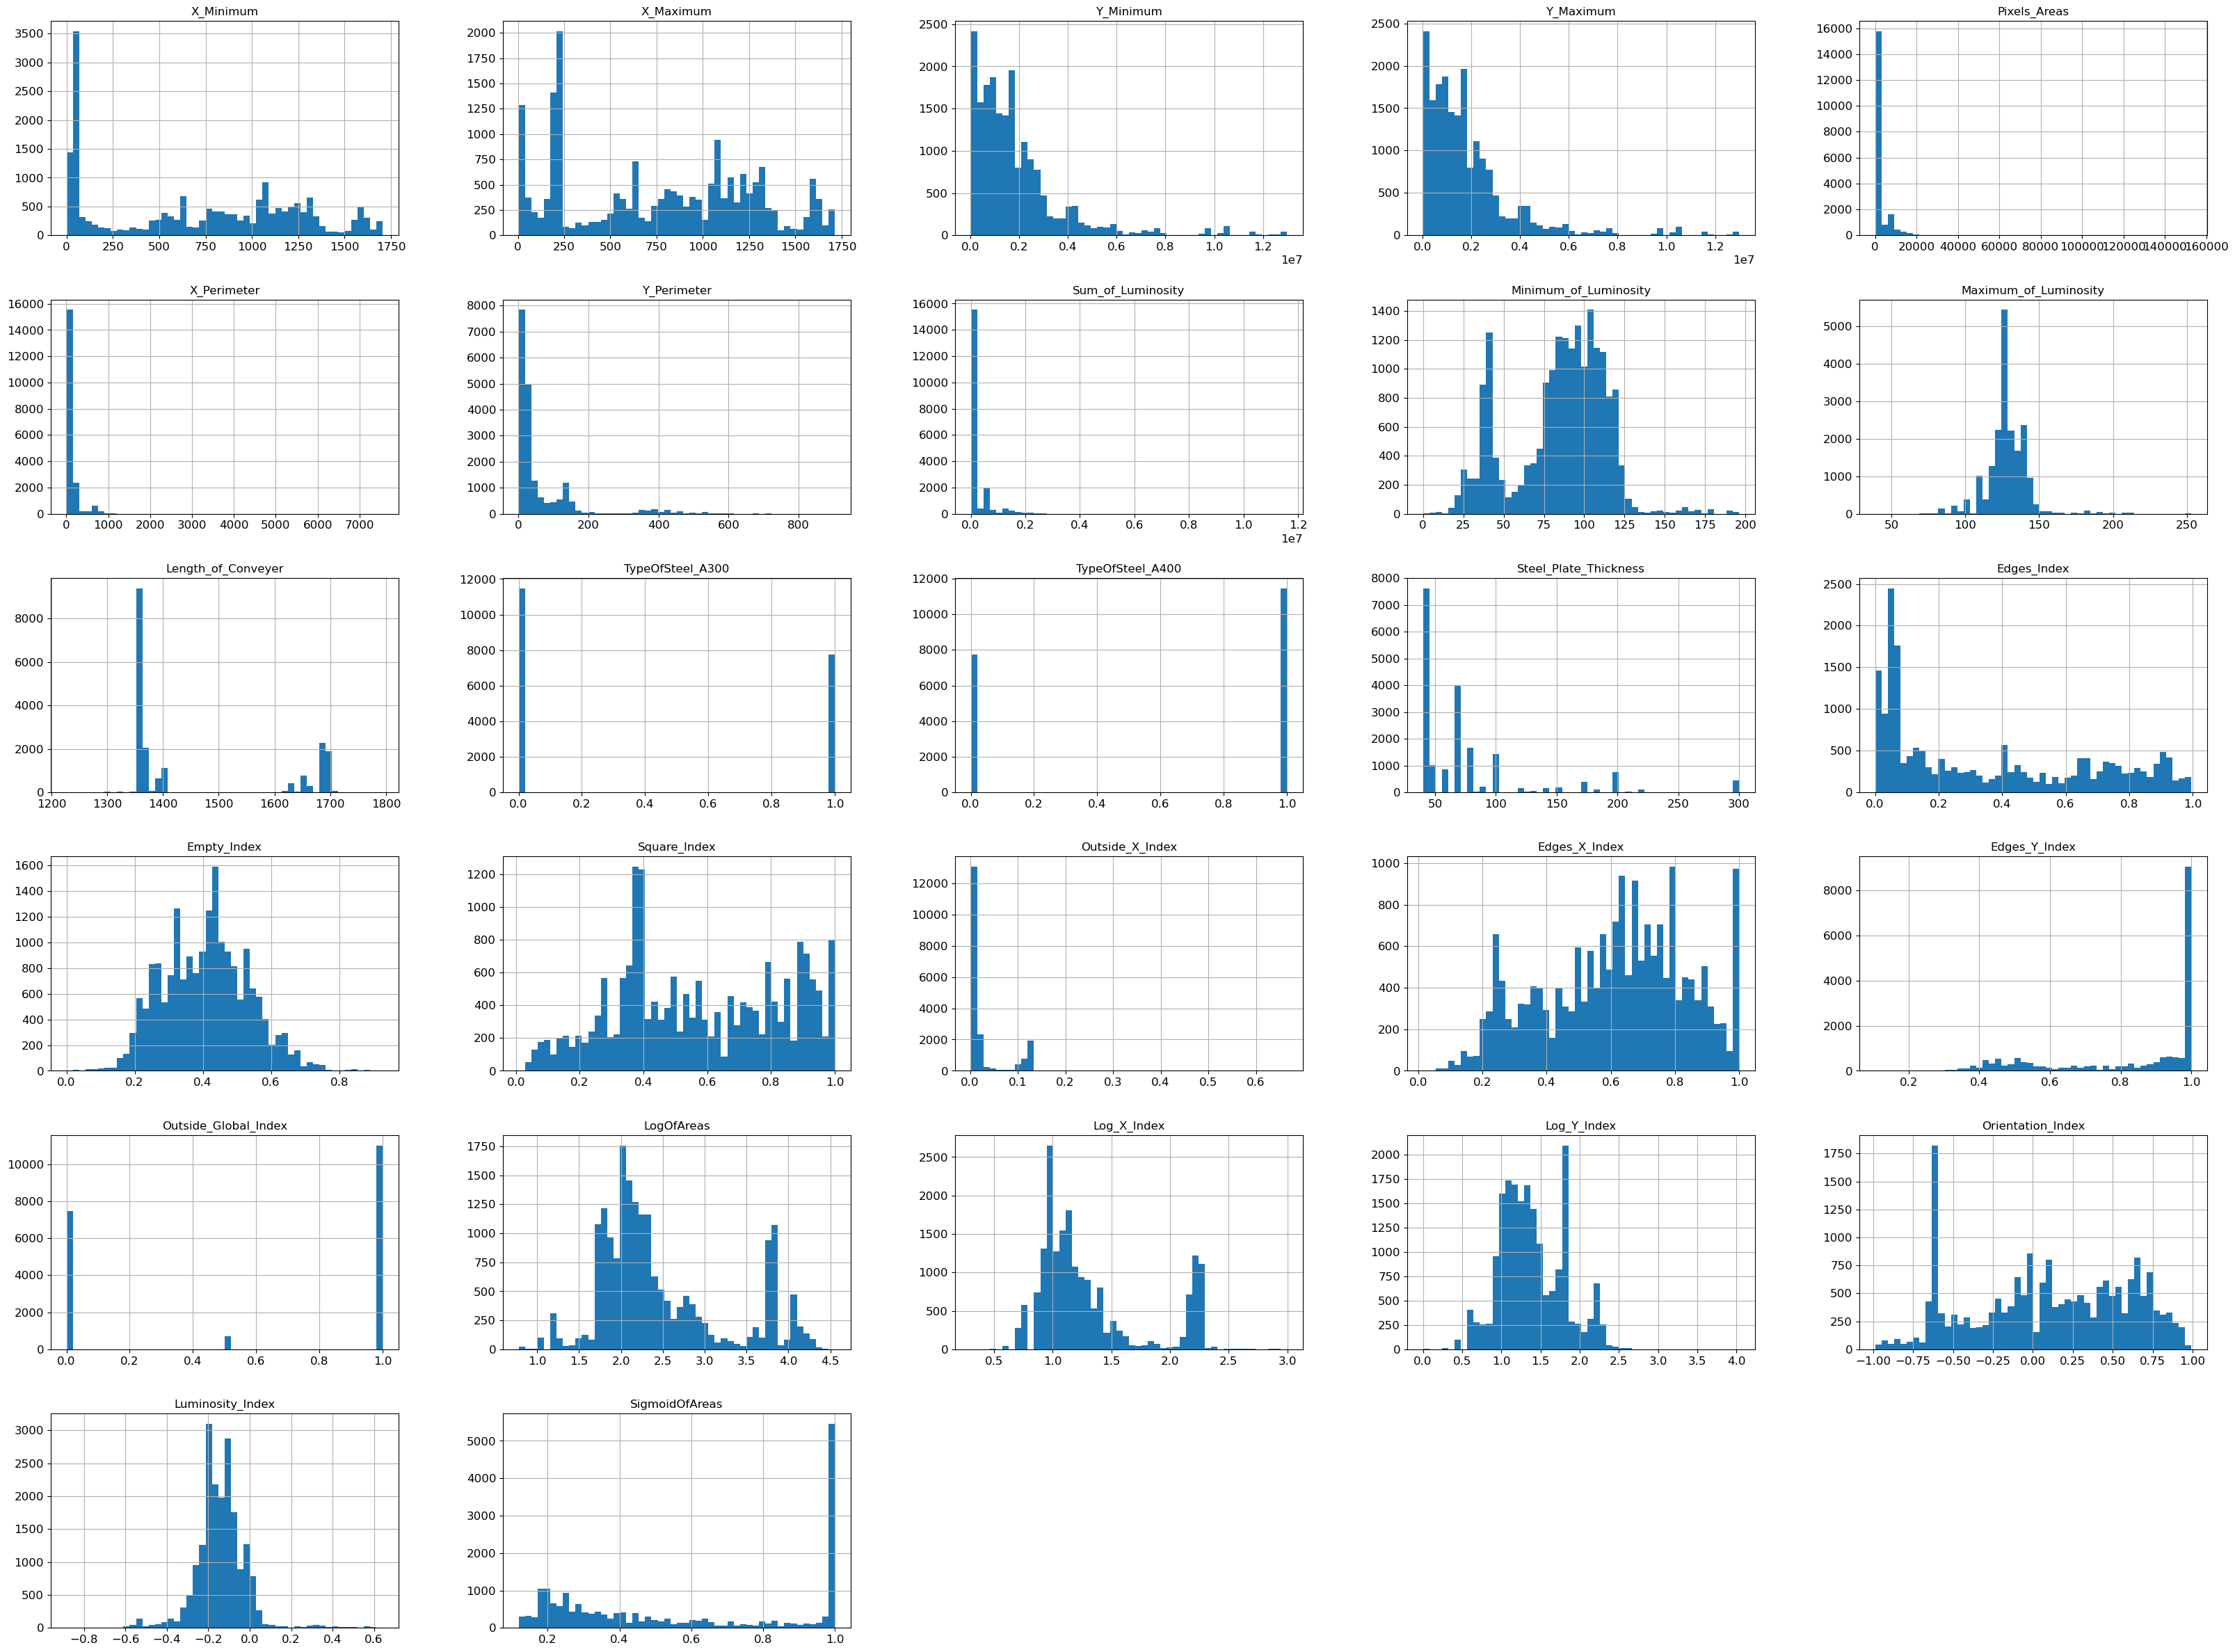

In [ ]:
import matplotlib.pyplot as plt

#TODO: Lag et penere plot

selected_atributes = raw_data[["X_Minimum","X_Maximum","Y_Minimum","Y_Maximum","Pixels_Areas","X_Perimeter","Y_Perimeter","Sum_of_Luminosity","Minimum_of_Luminosity","Maximum_of_Luminosity","Length_of_Conveyer","TypeOfSteel_A300","TypeOfSteel_A400","Steel_Plate_Thickness","Edges_Index","Empty_Index","Square_Index","Outside_X_Index","Edges_X_Index","Edges_Y_Index","Outside_Global_Index","LogOfAreas","Log_X_Index","Log_Y_Index","Orientation_Index","Luminosity_Index","SigmoidOfAreas"]]
selected_atributes.hist(bins=50, figsize=(40,30))
plt.show()

In [5]:
# Look for NaN values
missing_data = raw_data.isna().sum().sum()
print(f"Amount of missing data: {missing_data}") 

Amount of missing data: 0


### Get targets and Features

In [6]:
# Drop ID collum
raw_data_drop_id = raw_data.drop(columns=["id"])

# Split into features and target
initial_targets = ["Pastry","Z_Scratch","K_Scatch","Stains","Dirtiness","Bumps","Other_Faults"]
initial_features = [col for col in raw_data_drop_id.columns if col not in initial_targets]

## Look for corelations

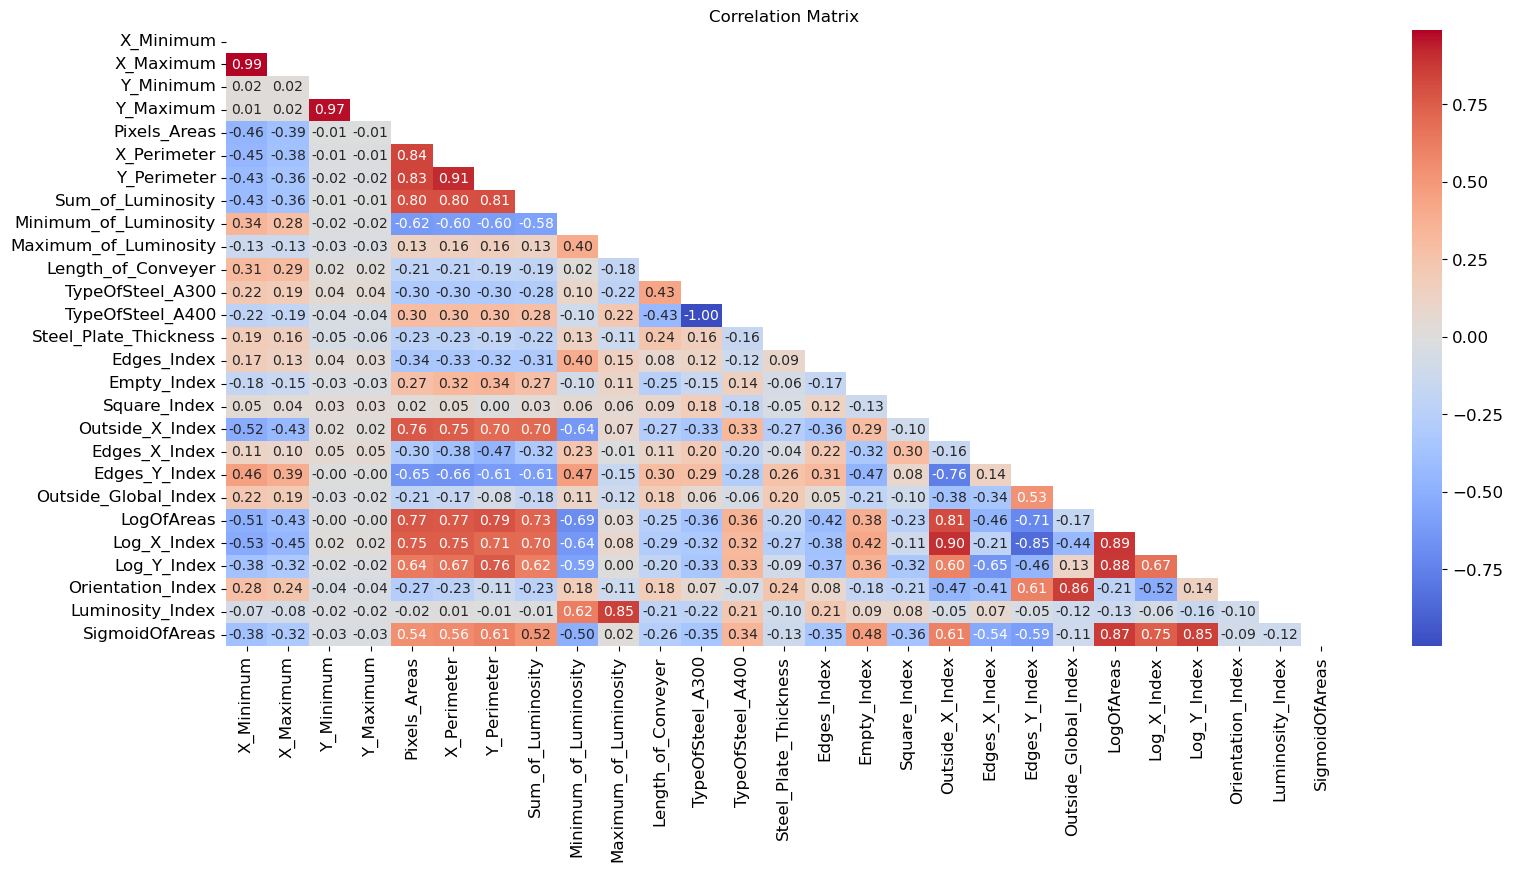

In [9]:
import seaborn as sns

corr = raw_data_drop_id[initial_features].corr()

plt.figure(figsize=(18, 8))
sns.heatmap(corr, annot=True,mask=np.triu(corr), cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show() 

### Identifying strongly corrolated data

If the attributes are redundant, remove them. This will help prevent overfitting.

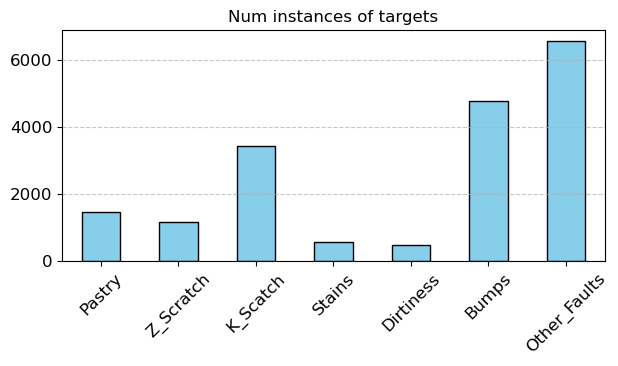

In [7]:
plot_target_distribution(raw_data, initial_targets)

# **Preparing The Data For Training**

In [8]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin

class AttributeSelecter(BaseEstimator, TransformerMixin):
    def __init__(self, add_length = False, drop_columns = False, merge_targets=False, drop_other_faults = False, **merge_kwargs):
        self.add_length = add_length
        self.drop_columns = drop_columns
        self.merge_targets = merge_targets
        self.drop_other_faults = drop_other_faults
        self.merge_kwargs = merge_kwargs

    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        X_transformed = X.copy()

        if self.merge_targets:

            for col, merge in self.merge_kwargs.items():
                if merge and col in X_transformed.columns:
                    X_transformed["Other_Faults"] += X_transformed[col]
                    X_transformed.drop(columns=[col], inplace=True)

        if self.drop_other_faults:
            # testing: remove other faults
            X_transformed = X_transformed[X_transformed["Other_Faults"] != 1]
            X_transformed.drop(columns=["Other_Faults"], inplace=True)

        # Add meaningful attribute (add_length does not improve performance)
        if self.add_length:
            X_transformed["Length"] = np.sqrt( (X["X_Maximum"] - X["X_Minimum"])**2 + (X["Y_Maximum"] - X["Y_Minimum"])**2 )

        # Drop specified columns
        if self.drop_columns:
            drop_columns = ["TypeOfSteel_A300", "id", "Outside_Global_Index"]
            # drop_columns = ['id', 'TypeOfSteel_A300', 'X_Minimum', 'Y_Minimum', 'X_Perimeter', 'Y_Perimeter', 'LogOfAreas', 'Outside_X_Index', 'Pixels_Areas', 'Square_Index', 'Sum_of_Luminosity', 'Edges_X_Index', 'Outside_Global_Index', 'SigmoidOfAreas', 'Edges_Y_Index', 'Log_X_Index']
            X_transformed.drop(columns = drop_columns, inplace=True)
        
        return X_transformed

In [ ]:
# Modify attributes
attribute_selecter = AttributeSelecter(merge_targets=True, drop_columns=True, drop_other_faults=True,
                                        Pastry=False,
                                        Dirtiness=False, 
                                        Bumps=False
                                       )
data_modified_attribs = attribute_selecter.transform(raw_data)

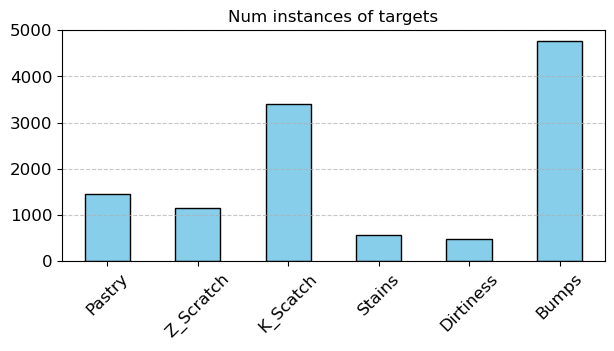

Num features: 25


['X_Minimum',
 'X_Maximum',
 'Y_Minimum',
 'Y_Maximum',
 'Pixels_Areas',
 'X_Perimeter',
 'Y_Perimeter',
 'Sum_of_Luminosity',
 'Minimum_of_Luminosity',
 'Maximum_of_Luminosity',
 'Length_of_Conveyer',
 'TypeOfSteel_A400',
 'Steel_Plate_Thickness',
 'Edges_Index',
 'Empty_Index',
 'Square_Index',
 'Outside_X_Index',
 'Edges_X_Index',
 'Edges_Y_Index',
 'LogOfAreas',
 'Log_X_Index',
 'Log_Y_Index',
 'Orientation_Index',
 'Luminosity_Index',
 'SigmoidOfAreas']

In [10]:
# Update new target and features
targets = [col for col in data_modified_attribs.columns if col in initial_targets]
features = [col for col in data_modified_attribs.columns if col not in targets]

plot_target_distribution(data_modified_attribs, targets)
print(f"Num features: {len(features)}")
features

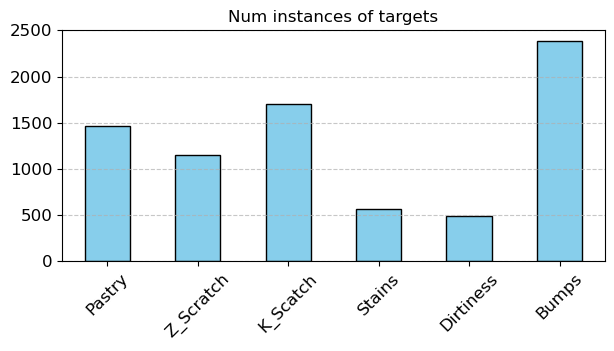

In [ ]:
# Undersample
data_modified_attribs = reduce_attribute(data_modified_attribs, "K_Scatch", 0.5)
data_modified_attribs = reduce_attribute(data_modified_attribs, "Bumps", 0.5)
plot_target_distribution(data_modified_attribs, targets)

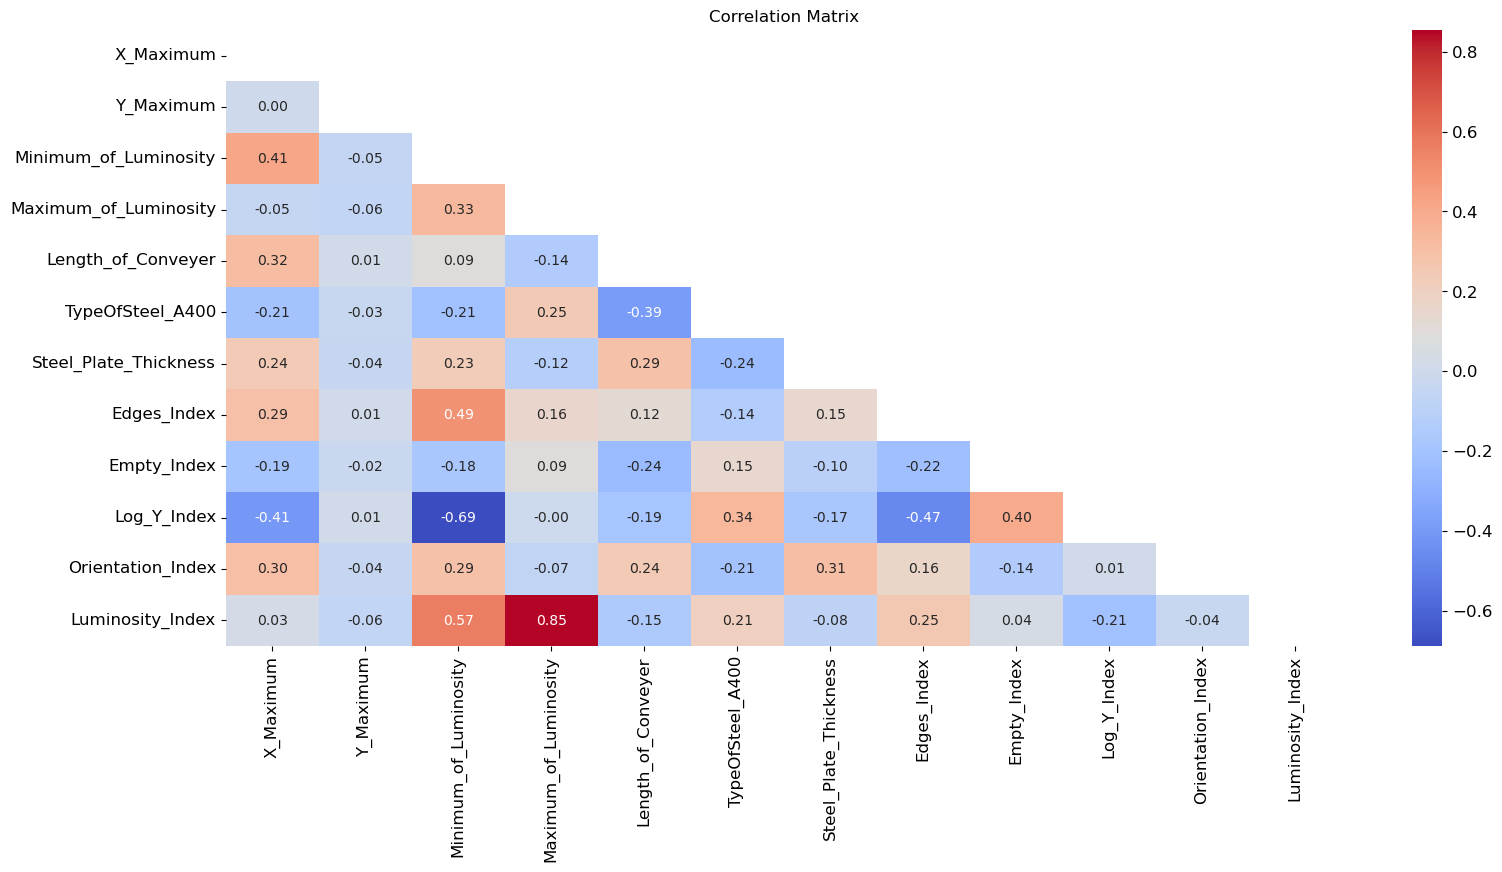

In [381]:
# Check correlation
corr = data_modified_attribs[features].corr()

plt.figure(figsize=(18, 8))
sns.heatmap(corr, annot=True,mask=np.triu(corr), cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show() 

## Scaling

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Scale the data
scaled_data = data_modified_attribs.copy()
scaled_data[features] = scaler.fit_transform(scaled_data[features])

In [29]:
from sklearn.model_selection import train_test_split

X = scaled_data[features].values
y = scaled_data[targets].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

print(f"Length test set: {len(X_train)} \nLength train set: {len(X_test)}")

y_train_1d = np.argmax(y_train, axis=1) # Not to be used
y_test_1d = np.argmax(y_test, axis=1)

Length test set: 10128 
Length train set: 2533


## Split into train and test

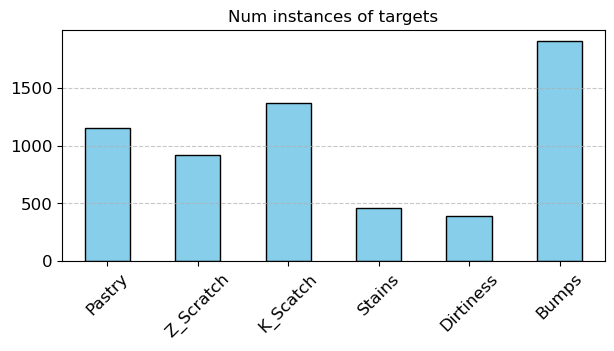

In [16]:
# Undersample
y_train = reduce_attribute(y_train, "K_Scatch", 0.5)
y_train = reduce_attribute(y_train, "Bumps", 0.5)
plot_target_distribution(y_train, targets)

### Convert to numpy arrays

# **Training**

## Random Forrest Classifier

### Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    'n_estimators': [80, 100, 120],
    'max_depth': [20, 30, 40],
    'min_samples_split': [3, 4, 5],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(class_weight='balanced', random_state=21)

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)

* **Run 1:** Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

* **Run 2:** Best parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 75}

* **Run 3 (excluding several attributes):** Best parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}

* **Good score with little overfit** n_estimators=50, max_features='sqrt', max_depth=10, min_samples_split=2, min_samples_leaf=1, random_state=21

* Best parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 120}

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# random_forrest_clf = RandomForestClassifier(n_estimators=75, max_features='sqrt', max_depth=20, min_samples_split=2, min_samples_leaf=20, random_state=21) # class_weight='balanced'

# Testing
random_forrest_clf = RandomForestClassifier(n_estimators=200, max_features='sqrt', max_depth=10, min_samples_split=2, min_samples_leaf=20, class_weight='balanced', random_state=21) # 

# Train the model
random_forrest_clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=20, n_estimators=150, random_state=21)

In [21]:
from sklearn.multiclass import OneVsRestClassifier

random_forrest_clf_OvR = OneVsRestClassifier(random_forrest_clf)
random_forrest_clf_OvR.fit(X_train, y_train)

OneVsRestClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                     max_depth=10,
                                                     min_samples_leaf=20,
                                                     n_estimators=150,
                                                     random_state=21))

In [22]:
y_pred_rf = random_forrest_clf.predict(X_test)
y_pred_rf_OvR = random_forrest_clf_OvR.predict(X_test)

print_accuracy(y_pred_rf, y_test)
print_accuracy(y_pred_rf_OvR, y_test)

Accuracy: 0.608
              precision    recall  f1-score   support

      Pastry       0.32      0.84      0.46       468
   Z_Scratch       0.75      0.67      0.70       231
    K_Scatch       0.98      0.88      0.93       678
      Stains       0.82      0.94      0.88       110
   Dirtiness       0.48      0.39      0.43        93
       Bumps       0.92      0.27      0.42       953

    accuracy                           0.61      2533
   macro avg       0.71      0.66      0.64      2533
weighted avg       0.79      0.61      0.61      2533

Accuracy: 0.722
              precision    recall  f1-score   support

      Pastry       0.46      0.65      0.54       468
   Z_Scratch       0.65      0.69      0.67       231
    K_Scatch       0.95      0.93      0.94       678
      Stains       0.80      0.99      0.89       110
   Dirtiness       0.30      0.17      0.22        93
       Bumps       0.79      0.64      0.71       953

    accuracy                           0.72  

In [23]:
y_pred_rf_train = random_forrest_clf_OvR.predict(X_train)

print_accuracy(y_pred_rf_train, y_train)

Accuracy: 0.755
              precision    recall  f1-score   support

      Pastry       0.50      0.69      0.58      1816
   Z_Scratch       0.68      0.82      0.74       919
    K_Scatch       0.95      0.93      0.94      2735
      Stains       0.76      0.98      0.86       458
   Dirtiness       0.53      0.36      0.43       392
       Bumps       0.84      0.65      0.74      3808

    accuracy                           0.76     10128
   macro avg       0.71      0.74      0.71     10128
weighted avg       0.78      0.76      0.76     10128



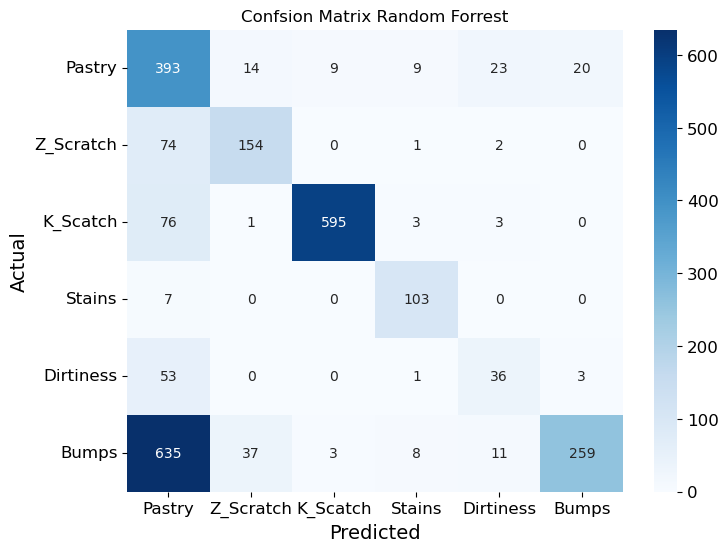

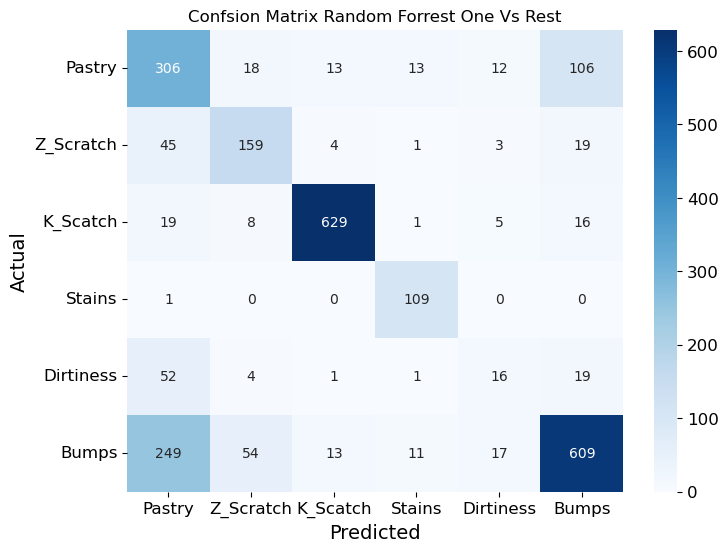

In [24]:
plot_confusion_matrix(y_test, y_pred_rf, targets, title="Confsion Matrix Random Forrest")
plot_confusion_matrix(y_test, y_pred_rf_OvR, targets, title="Confsion Matrix Random Forrest One Vs Rest")

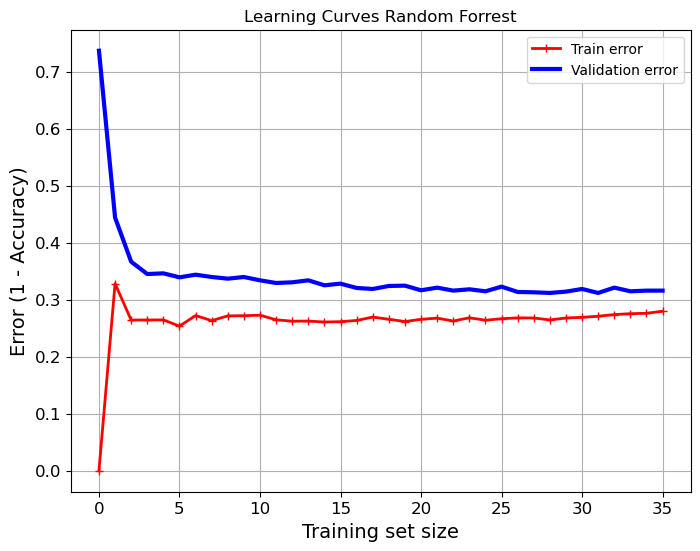

In [174]:
plot_learning_curves(random_forrest_clf, X_train, X_test, y_train, y_test, title="Learning Curves Random Forrest", min_data_length=1, step_size=200)

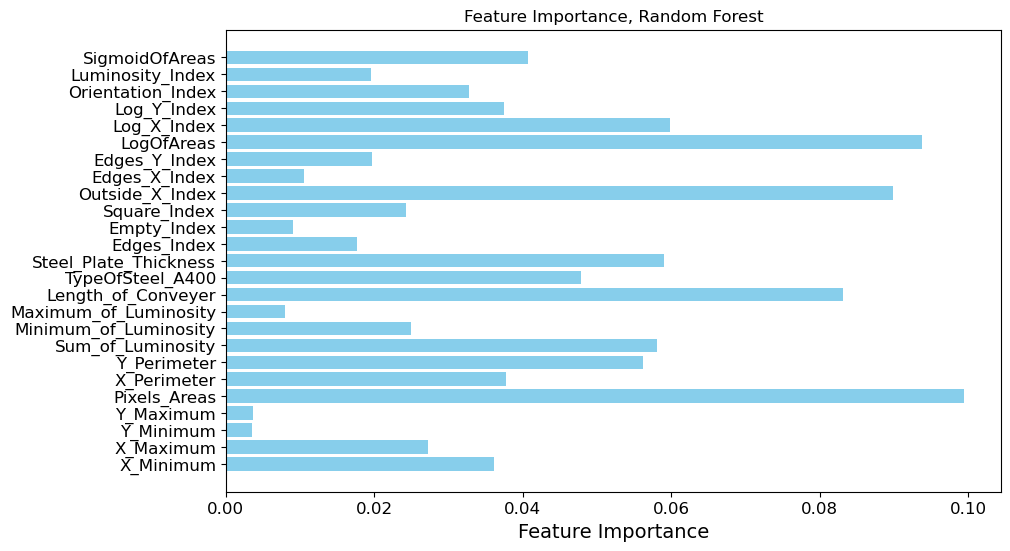

In [175]:
# Feature Importance Plot
importances = random_forrest_clf.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(features, importances, color="skyblue")
plt.xlabel("Feature Importance")
plt.title("Feature Importance, Random Forest")
plt.show()

## Gradient Boosting Classifier

### Randomized Search (faster)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier


gb_clf = GradientBoostingClassifier()

param_dist = {
    "n_estimators": [50, 75, 100],
    "learning_rate": [0.1, 0.05, 0.01],
    "max_depth": [6, 8, 19],
    "min_samples_split": [50, 70, 90],
    "min_samples_leaf": [20, 30, 40],
    "subsample": [0.7, 0.8, 0.9]
}

random_search = RandomizedSearchCV(gb_clf, param_distributions=param_dist, n_iter=20, cv=5, scoring="accuracy", random_state=21)
random_search_OvA = OneVsRestClassifier(random_search)

random_search_OvA.fit(X_train, y_train)

print("Best parameters:", random_search.best_params_)


* Best parameters: {'subsample': 0.8, 'n_estimators': 100, 'min_samples_split': 50, 'min_samples_leaf': 20, 'max_depth': 6, 'learning_rate': 0.05}

In [176]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.multiclass import OneVsRestClassifier

# Init GradientBoostingClassifier
gradient_boosting_clf = GradientBoostingClassifier(subsample=0.7, n_estimators=100, min_samples_split=200, min_samples_leaf=100, max_depth=4, learning_rate=0.05, random_state=21)

# Create one vs rest for it to work with multiple classes
gradient_boosting_clf_OvA = OneVsRestClassifier(gradient_boosting_clf)

# Training
gradient_boosting_clf_OvA.fit(X_train, y_train)

OneVsRestClassifier(estimator=GradientBoostingClassifier(learning_rate=0.05,
                                                         max_depth=4,
                                                         min_samples_leaf=100,
                                                         min_samples_split=200,
                                                         random_state=21,
                                                         subsample=0.7))

In [177]:
# Predict
y_pred_gb = gradient_boosting_clf_OvA.predict(X_test)

print_accuracy(y_pred_gb, y_test)

# y_pred_gb = gradient_boosting_clf_OvA.predict(X_train)

# print_accuracy(y_pred_gb, y_train)

Accuracy: 0.676
              precision    recall  f1-score   support

      Pastry       0.45      0.70      0.55       451
   Z_Scratch       0.83      0.71      0.76       222
    K_Scatch       0.95      0.93      0.94       339
      Stains       0.94      0.85      0.89       124
   Dirtiness       0.80      0.27      0.40       105
       Bumps       0.68      0.50      0.58       474

    accuracy                           0.68      1715
   macro avg       0.77      0.66      0.69      1715
weighted avg       0.72      0.68      0.68      1715



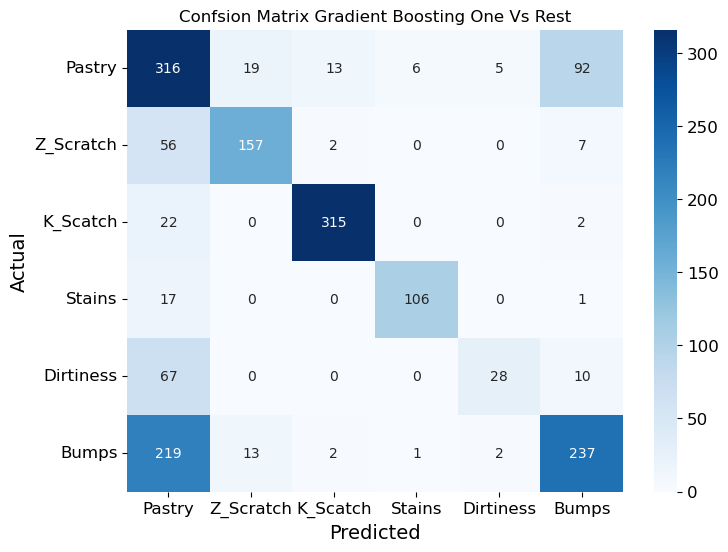

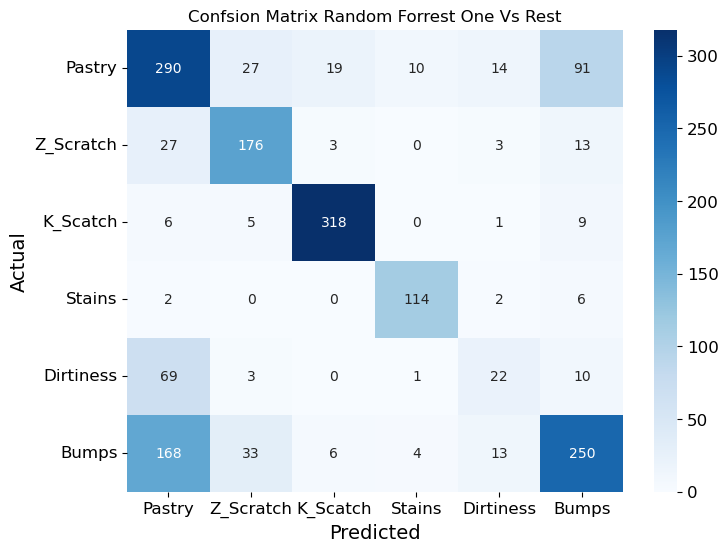

In [178]:
plot_confusion_matrix(y_test, y_pred_gb, targets, title="Confsion Matrix Gradient Boosting One Vs Rest")
plot_confusion_matrix(y_test, y_pred_rf_OvR, targets, title="Confsion Matrix Random Forrest One Vs Rest")


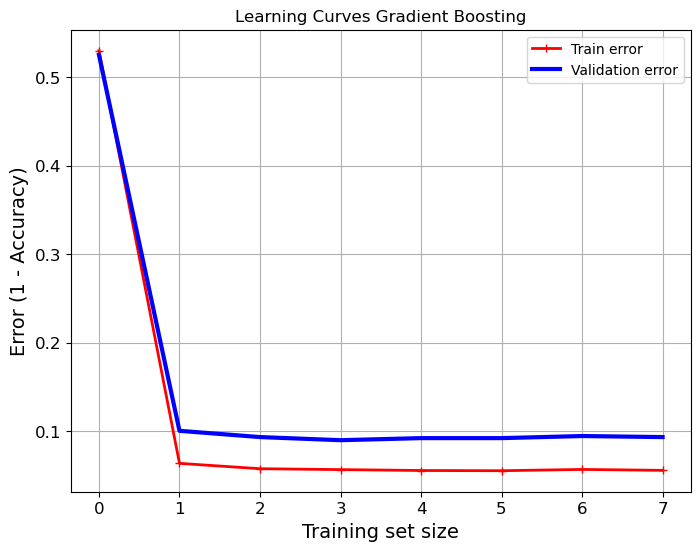

In [126]:
plot_learning_curves(gradient_boosting_clf_OvA, X_train, X_test, y_train, y_test, title="Learning Curves Gradient Boosting", min_data_length=100, step_size=500)

# SVM

In [71]:
# Importer nødvendige biblioteker
from sklearn.svm import SVC

svm_clf = SVC(C=1, kernel='rbf', gamma=0.1, random_state=21)

svm_clf_OvA = OneVsRestClassifier(svm_clf)

svm_clf_OvA.fit(X_train, y_train)

OneVsRestClassifier(estimator=SVC(C=1, gamma=0.1, random_state=21))

In [72]:
y_pred_SVM = svm_clf_OvA.predict(X_test)

print_accuracy(y_pred_SVM, y_test)

Accuracy: 0.629
              precision    recall  f1-score   support

      Pastry       0.42      0.75      0.54       451
   Z_Scratch       0.78      0.52      0.63       222
    K_Scatch       0.95      0.91      0.93       339
      Stains       0.95      0.78      0.86       124
   Dirtiness       1.00      0.10      0.17       105
       Bumps       0.64      0.44      0.52       474

    accuracy                           0.63      1715
   macro avg       0.79      0.58      0.61      1715
weighted avg       0.71      0.63      0.62      1715



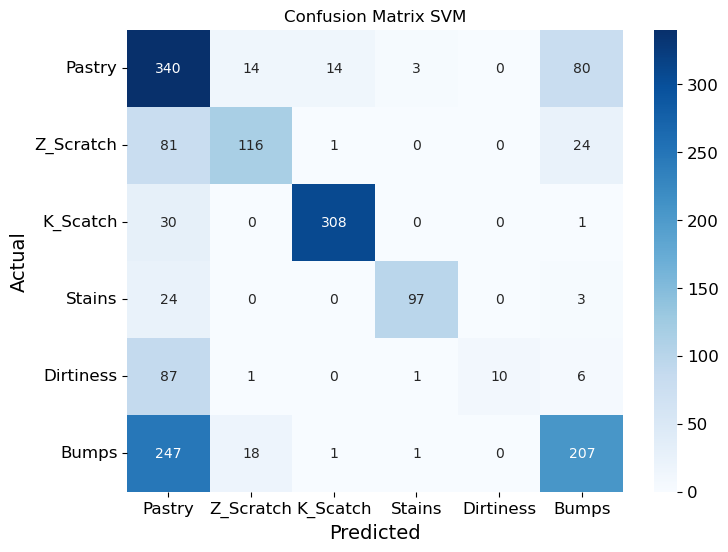

In [92]:
plot_confusion_matrix(y_test, y_pred_SVM, targets, title="Confusion Matrix SVM")

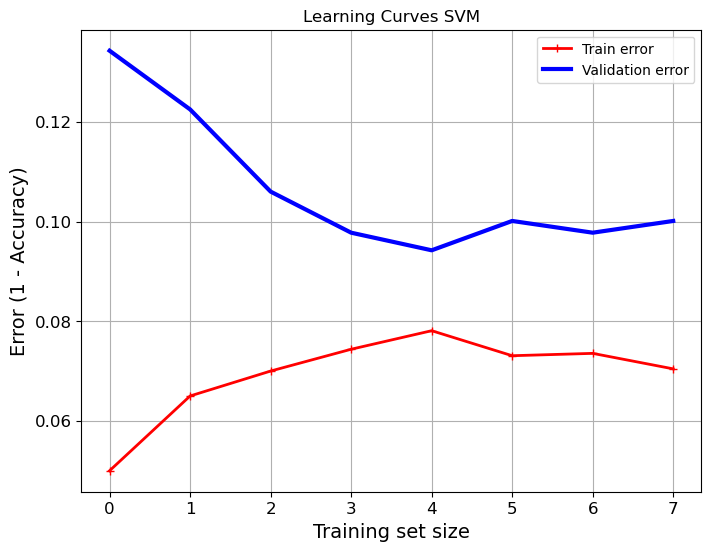

In [130]:
plot_learning_curves(svm_clf_OvA, X_train, X_test, y_train, y_test, title="Learning Curves SVM", min_data_length=100, step_size=500)

# Stacked Model

In [179]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression


svm_clf = SVC(C=1, kernel='rbf', gamma=0.3, random_state=21)
gradient_boosting_clf = GradientBoostingClassifier(subsample=0.7, n_estimators=100, min_samples_split=200, min_samples_leaf=100, max_depth=4, learning_rate=0.05, random_state=21)

base_models = [
    ('rf', RandomForestClassifier(n_estimators=50, max_features='sqrt', max_depth=10, min_samples_split=2, min_samples_leaf=1, random_state=21)),
    ('gb', OneVsRestClassifier(gradient_boosting_clf)),
    ('svm', OneVsRestClassifier(svm_clf)),
]

# Define the final model
final_estimator = LogisticRegression()

# Define the stacking ensemble
stacked_model = MultiOutputClassifier(StackingClassifier(estimators=base_models, final_estimator=final_estimator, cv=5))

TRAIN_MODEL = True
if TRAIN_MODEL:
    # Fit the model on the training data
    stacked_model.fit(X_train, y_train)

In [180]:
# Get probabilities
y_pred_stacked = stacked_model.predict(X_test)

In [181]:
print_accuracy(y_pred_stacked, y_test)

Accuracy: 0.675
              precision    recall  f1-score   support

      Pastry       0.45      0.70      0.55       451
   Z_Scratch       0.84      0.70      0.76       222
    K_Scatch       0.95      0.93      0.94       339
      Stains       0.96      0.82      0.89       124
   Dirtiness       0.83      0.23      0.36       105
       Bumps       0.67      0.52      0.59       474

    accuracy                           0.68      1715
   macro avg       0.78      0.65      0.68      1715
weighted avg       0.72      0.68      0.68      1715



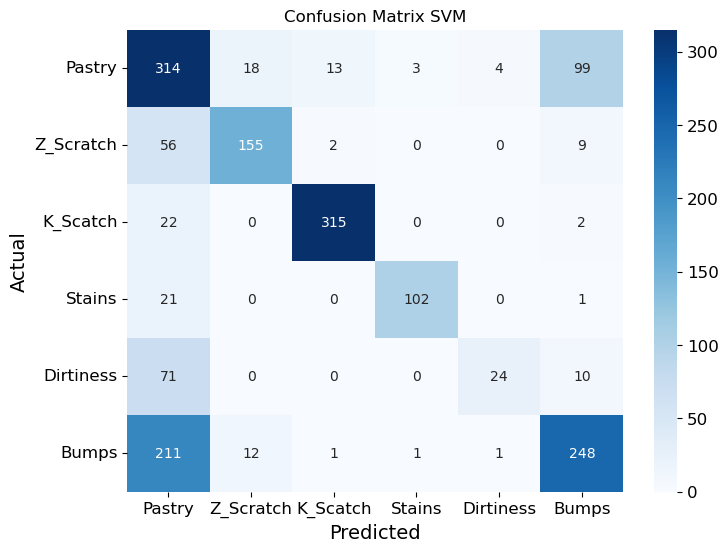

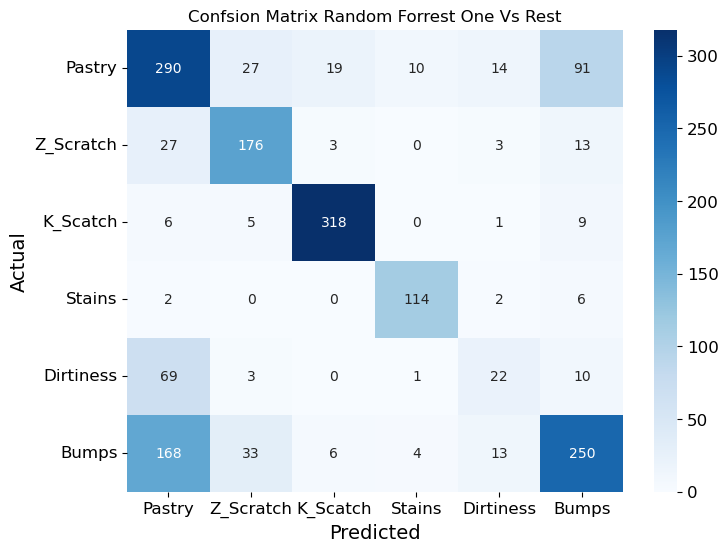

In [182]:
plot_confusion_matrix(y_test, y_pred_stacked, targets, title="Confusion Matrix SVM")
plot_confusion_matrix(y_test, y_pred_rf_OvR, targets, title="Confsion Matrix Random Forrest One Vs Rest")

In [183]:
from sklearn.metrics import roc_auc_score
import numpy as np

# Predict on validation data
predictions_val = stacked_model.predict_proba(X_test)

# Beregn AUC for hver klasse
auc_scores = [roc_auc_score(y_test[:, i], predictions_val[i][:, 1]) for i in range(y_test.shape[1])]
mean_auc = np.mean(auc_scores)
print("Mean AUC Score: ", mean_auc)

Mean AUC Score:  0.9342269671499137


# 💣 Mi BOMBOCLAT 

# Dimensionality Reduction

In [122]:
from sklearn.decomposition import PCA
d = 20
pca = PCA(n_components=d)
X_pca = pca.fit_transform(X)

X_train_red, X_test_red, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=21)

In [123]:
# Init GradientBoostingClassifier
gb1 = GradientBoostingClassifier(subsample=0.7, n_estimators=100, min_samples_split=200, min_samples_leaf=100, max_depth=4, learning_rate=0.05, random_state=21)
gb2 = GradientBoostingClassifier(subsample=0.7, n_estimators=100, min_samples_split=200, min_samples_leaf=100, max_depth=4, learning_rate=0.05, random_state=21)

In [124]:
gb_OvR = OneVsRestClassifier(gb1)
gb_OvR.fit(X_train, y_train)

gb_OvR_red = OneVsRestClassifier(gb2)
gb_OvR_red.fit(X_train_red, y_train)

OneVsRestClassifier(estimator=GradientBoostingClassifier(learning_rate=0.05,
                                                         max_depth=4,
                                                         min_samples_leaf=100,
                                                         min_samples_split=200,
                                                         random_state=21,
                                                         subsample=0.7))

In [125]:
# Predict
y_pred = gb_OvR.predict(X_test)
y_pred_red = gb_OvR_red.predict(X_test_red)

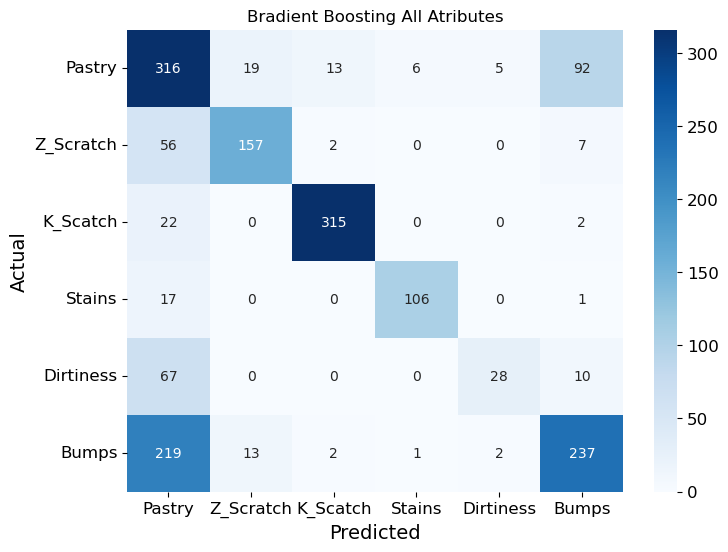

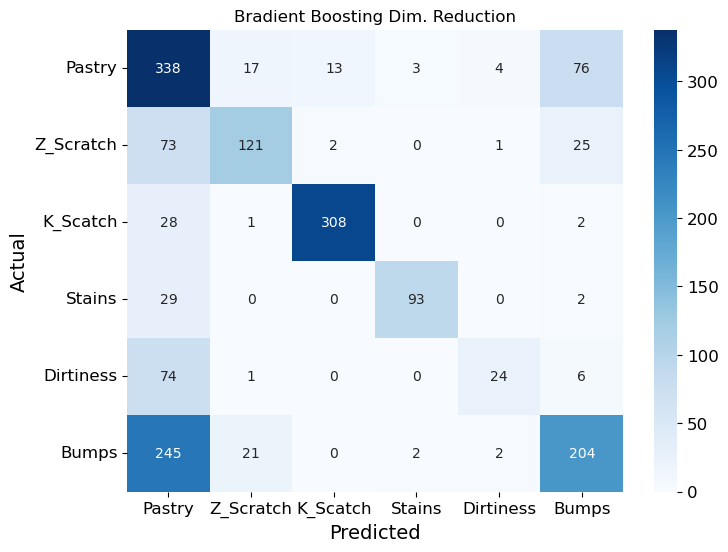

In [126]:
plot_confusion_matrix(y_test, y_pred, targets, title="Bradient Boosting All Atributes")
plot_confusion_matrix(y_test, y_pred_red, targets, title="Bradient Boosting Dim. Reduction")